<a href="https://colab.research.google.com/github/mhask94/cs474_labs_f2019/blob/conv2linear/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports for training data
!if ( ! ls . | grep pytransform ); then git clone https://github.com/mhask94/pytransform.git; fi
# !git clone https://github.com/mhask94/pytransform.git
from pytransform.common import skew
from pytransform.quaternion import Quaternion as Quat
import numpy as np

Cloning into 'pytransform'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 65 (delta 6), reused 14 (delta 6), pack-reused 51
Unpacking objects: 100% (65/65), done.


In [0]:
# imports for pytorch
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.core.debugger import set_trace

In [0]:
# classes for quadrotor state and dynamics
class State():
    def __init__(self, arr=np.empty(0)):
        if len(arr) == 0:
            self.arr = np.zeros((10,1), dtype=np.float64)
            self.arr[3] = 1
        else:
            assert arr.shape == (10, 1)
            if not arr.dtype == np.float64:
              arr = np.array(arr, dtype=np.float64)
            arr.dtype = np.float64
            self.arr = arr

    def __getitem__(self, position):
        return self.arr[position]
    def __str__(self):
        s = 'p: ' + str(self.p.flatten()) + '\nq: ' + self.q.__str__() + \
                '\nv: ' + str(self.v.flatten())
        s = s.replace('[ ', '[')
        s = s.replace(', ', ' ')
        s = s.replace(' ]', ']')
        return s
    def __repr__(self):
        return self.__str__()
    def __add__(self, other):
        assert other.shape == (9, 1)
        out = np.empty(self.arr.shape)
        out[:3]  = self.p + other[:3]
        out[3:7] = (self.q + other[3:6]).elements
        out[7:]  = self.v + other[6:]
        return State(out)
    def __iadd__(self, other):
        assert other.shape == (9, 1)
        self.arr[:3] += other[:3]
        self.arr[3:7] = (self.q + other[3:6]).elements
        self.arr[7:] += other[6:]
        return self
    @property
    def p(self):
        return self.arr[:3]
    @property
    def q(self):
        return Quat(self.arr[3:7])
    @property
    def v(self):
        return self.arr[7:]
    @property
    def elements(self):
        return self.arr.copy()
    def copy(self):
        return State(self.arr.copy())

class Dynamics():
    def __init__(self):
        self.k1 = np.zeros((9,1))
        self.k2 = np.zeros((9,1))
        self.k3 = np.zeros((9,1))
        self.k4 = np.zeros((9,1))
        self.cd = 0.1
        e_z = np.array([[0,0,1]]).T
        self.g = 9.8065 * e_z
        self.se = 0.5

    def run(self, xu, dt):
        x,u = State(xu[:10]), xu[10:]
        self.k1 = self.f(x, u)
        self.k2 = self.f(x + self.k1*(dt/2), u)
        self.k3 = self.f(x + self.k2*(dt/2), u)
        self.k4 = self.f(x + self.k3*dt, u)
        # x += (self.k1 + 2*(self.k2 + self.k3) + self.k4) * (dt/6)
        return x + (self.k1 + 2*(self.k2 + self.k3) + self.k4) * (dt/6)

    def f(self, x, u):
        s, w = u[0], u[1:]
        dx = np.empty(self.k1.shape)
        dx[:3] = x.q.rota(x.v)
        dx[3:6] = w
        dx[6:] = -self.g*(s/self.se) - self.cd*x.v + x.q.rotp(self.g) - \
                skew(w) @ x.v
        return dx

    @property
    def state(self):
        return self.x.copy()

In [0]:
class DataGenerator():
  def __init__(self, num_states, num_inputs, dt=0.01, batch_size=50):
    self.n = num_states
    self.m = num_inputs
    self.dt = dt
    self.batch_size = batch_size
    self.pos_lim = 50
    self.att_lim = np.pi/3.5
    self.vel_lim = 10
    self.rate_lim = np.pi
    self.s_lim = 1
    self.dyn = Dynamics()

  def getRandomInput(self):
    xu = np.empty(self.n + self.m)
    xu[:2] = np.random.uniform(-self.pos_lim, self.pos_lim, 2)
    xu[2] = np.random.uniform(-self.pos_lim, 0)
    mask = np.random.uniform(size=3) > 0.2
    euler = np.random.uniform(-self.att_lim, self.att_lim, 3) * mask
    xu[3:7] = Quat.from_euler(*euler).elements.flatten()
    xu[7:10] = np.random.uniform(-self.vel_lim, self.vel_lim, 3)
    xu[10] = np.random.uniform(0, self.s_lim)
    xu[11:] = np.random.uniform(-self.rate_lim, self.rate_lim, 3)
    return xu

  def getBatch(self):
    batch_in = np.empty((self.batch_size, self.n+self.m))
    batch_out = np.empty((self.batch_size, self.n))
    for i in range(self.batch_size):
      batch_in[i] = self.getRandomInput()
      batch_out[i] = self.dyn.run(batch_in[i].reshape(-1,1), self.dt).elements.flatten()
    return batch_in, batch_out

In [5]:
def testGen():
  data_gen = DataGenerator(10,4,dt=0.01,batch_size=2)
  ran = data_gen.getRandomInput()
  print('rand: ', ran)

  x, truth = data_gen.getBatch()
  print('x: \n', x)
  print('truth: \n', truth)

  dyn = Dynamics()
  for i, state in enumerate(x):
    state = state.reshape(-1,1)
    out = dyn.run(state, 0.01).elements.flatten()
    error = out - truth[i]
    norm = np.sqrt(error @ error)
    print('norm: ', norm)

testGen()

rand:  [-3.81085565e+01 -3.91763828e+01 -3.63731190e+01  9.81004447e-01
  9.76446524e-03 -1.92829636e-03 -1.93729739e-01 -6.42299717e+00
 -4.28974423e+00  6.92848157e-02  9.40049592e-01  2.85486518e+00
 -9.69561734e-01 -1.70965377e+00]
x: 
 [[-4.71541780e+01 -3.72224203e+01 -3.14312599e+01  9.01655870e-01
  -1.38416736e-01  2.52143653e-01 -3.22925810e-01  7.40986180e+00
  -8.54192238e+00 -8.08164061e+00  9.99742037e-01  2.93108603e+00
  -1.53090796e+00 -2.90044392e+00]
 [-1.18729001e+01 -1.15910614e+01 -9.99342729e+00  9.30630159e-01
  -3.59331179e-01 -6.28030293e-02 -2.94005237e-02 -8.25515893e+00
  -7.40695137e-01 -4.56977033e+00  7.40130835e-01  2.89424880e+00
   5.00275231e-01  4.19208831e-01]]
truth: 
 [[-4.71932128e+01 -3.73421067e+01 -3.14908436e+01  9.00713336e-01
  -1.31298169e-01  2.38442048e-01 -3.38558217e-01  7.49282871e+00
  -8.59340939e+00 -8.04989235e+00]
 [-1.19509132e+01 -1.16269481e+01 -1.00334582e+01  9.35946249e-01
  -3.45882854e-01 -6.01406484e-02 -2.74367032e-02 

In [6]:
def testLinearSize():
  inputs = 14
  outputs = 10
  batch = 1
  x_test = torch.zeros(batch,inputs)
  up = nn.Linear(inputs, 50)
  up_test = up(x_test)
  print('up: ', up_test.size())

  down = nn.Linear(50, outputs)
  down_test = down(up_test)
  print('down: ', down_test.size())

testLinearSize()

up:  torch.Size([1, 50])
down:  torch.Size([1, 10])


In [0]:
class ResBlock(nn.Module):
  def __init__(self, dim_in, dim_out, skip=False, end=False):
    super(ResBlock, self).__init__()
    self.skip = skip
    self.end = end
    self.activation = nn.ReLU()
    self.layer1 = nn.Linear(dim_in, dim_in)
    self.layer2 = nn.Linear(dim_in, dim_in)
    self.layer3 = nn.Linear(dim_in, dim_out)

  def forward(self, x):
    out1 = self.activation(self.layer1(x))
    out2 = self.layer2(out1)
    skip = self.activation(out2 + out1)
    if self.end:
      out3 = self.layer3(skip)
    else:
      out3 = self.activation(self.layer3(skip))
    if self.skip:
      return skip, out3
    else:
      return out3

class DynamicsNN(nn.Module):
  def __init__(self, num_states, num_inputs, dt):
    super(DynamicsNN, self).__init__()
    self.dt = dt
    self.activation = nn.ReLU()
    self.up1 = nn.Linear(num_states+num_inputs, 50)
    self.up2 = ResBlock(50,  100, skip=True)
    self.up3 = ResBlock(100, 200, skip=True)
    self.dn1 = ResBlock(200, 100)
    self.dn2 = ResBlock(100, 50)
    self.dn3 = ResBlock(50,  num_states, end=True)

  def forward(self, x):
    up1 = self.activation(self.up1(x))
    skip1, up2 = self.up2(up1)
    skip2, up3 = self.up3(up2)
    down1 = self.dn1(up3)
    down2 = self.dn2(skip2 + down1)
    down3 = self.dn3(skip1 + down2)
    p = down3[:,:3] + x[:,:3] + x[:,7:10]*self.dt
    w = torch.zeros_like(down3[:,3:7])
    w[:,1:] = x[:,4:7]
    q = down3[:,3:7] + x[:,3:7] + w*self.dt
    q1 = torch.zeros_like(q)
    q1 = q / torch.norm(q, dim=1, keepdim=True)
    # was getting nans here, but removing ReLU on output layer fixed it
    # norm = torch.norm(q, dim=1)
    # mask = norm != 0.0
    # q1[mask] = q[mask] / norm[mask].unsqueeze(-1)
    v = down3[:,7:] + x[:,7:10]
    out = torch.cat((p,q1,v), dim=1)
    return out

In [20]:
def testNet():
  n = 10
  m = 4
  dt = 0.01
  x_test = torch.randn(2,n+m)
  print('x_test: ', x_test)
  net = DynamicsNN(n,m, dt)
  test = net(x_test)
  print('shape: ', test.shape)
  print('output: ', test)

testNet()

x_test:  tensor([[ 0.6027, -0.4907,  0.1397, -1.6363,  0.1256, -0.6441, -1.5072, -0.2153,
         -0.1257, -0.3266, -1.6617,  0.5776,  0.7538, -0.6094],
        [ 1.9939, -0.7580, -1.0585, -0.2426,  1.0348,  2.2233,  0.3213,  0.8090,
         -0.2408,  1.0777, -0.0496,  0.6603,  0.2110,  0.2761]])
shape:  torch.Size([2, 10])
output:  tensor([[ 0.6789, -0.5257,  0.1323, -0.7044, -0.0109, -0.3051, -0.6407, -0.2535,
         -0.0627, -0.3274],
        [ 2.0916, -0.7751, -1.0550, -0.0193,  0.3719,  0.9064,  0.1996,  0.7377,
         -0.1814,  1.0955]], grad_fn=<CatBackward>)


In [0]:
def validate(model, optimizer, loss_fn)

Last saved loss: 98.373, e: 990: 100%|██████████| 1000/1000 [03:16<00:00,  5.07it/s]


Nans:  0
sample input:  [  9.31781675  25.31751542 -34.80151406   0.98960562   0.
   0.           0.14380791  -1.27667522  -5.12424687  -8.90926277
   0.11808945  -1.01724059   2.4267579    1.89107203]
true output:  [ 9.32016105e+00  2.52647844e+01 -3.48901878e+01  9.88116041e-01
 -6.77797337e-03  1.12757368e-02  1.53145703e-01 -1.15625096e+00
 -5.00605151e+00 -8.90650355e+00]
predicted output:  tensor([ 8.7857e+00,  2.5015e+01, -3.5076e+01,  9.9469e-01, -2.1614e-02,
         5.6145e-02,  8.3452e-02, -1.3131e+00, -6.2060e+00, -9.2282e+00],
       device='cuda:0', grad_fn=<SelectBackward>)


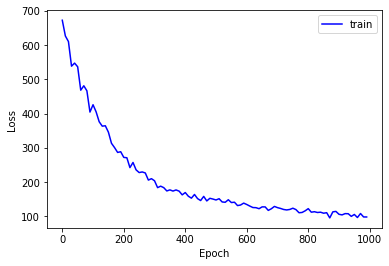

In [21]:
def train(save_model):
  n = 10
  m = 4
  dt = 0.01
  model = DynamicsNN(n, m, dt).cuda()

  lr = 1e-5
  optimizer = torch.optim.Adam(model.parameters(), lr)
  loss_fn = nn.MSELoss()

  epochs = 1000
  batch_size = 500
  data_gen = DataGenerator(n, m, dt, batch_size)

  save_every = 10
  decay_every = 100
  # validate_every = 1000

  epoch_hist = []
  loss_hist = []
  # vals = []

  num_nans = 0

  last_l = 0
  last_e = 0
  info = tqdm(total=epochs, position=0, leave=False)
  for epoch in range(epochs):
    optimizer.zero_grad()

    xu_t, x_tp1 = data_gen.getBatch()
    in_var = Variable(torch.from_numpy(xu_t).float(), requires_grad=True).cuda()
    out_truth = Variable(torch.from_numpy(x_tp1).float(), requires_grad=False).cuda()

    out_pred = model(in_var)

    position_loss = loss_fn(out_pred[:,:3], out_truth[:,:3])
    attitude_loss = loss_fn(out_pred[:,3:7]*100, out_truth[:,3:7]*100)
    velocity_loss = loss_fn(out_pred[:,7:], out_truth[:,7:])
    loss = position_loss + attitude_loss + velocity_loss 
    #loss = loss_fn(out_pred, out_truth)

    loss.backward()
    optimizer.step()

    # was getting nans in out_pred and loss because / by 0 in norm calculation 
    # until I removed ReLU from last layer
    loss = loss.item()
    if np.isnan(loss):
      num_nans += 1

    # if epoch % validate_every == 0:
      # validate()

    if epoch % save_every == 0:
      last_l = loss
      last_e = epoch
      epoch_hist.append(epoch)
      loss_hist.append(loss)
      if save_model:
        torch.save(model, 'learned_quadrotor_model.pt')
    
    if epoch % decay_every == 0:
      lr *= 0.9
      for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    info.set_description('Last saved loss: {:.3f}, e: {}'.format(last_l,last_e))
    info.update(1)
  
  fig, ax = plt.subplots()
  train_losses, = ax.plot(epoch_hist, loss_hist, 'b', label='train')
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Loss')
  ax.legend()
  print('\nNans: ', num_nans)
  print('sample input: ', xu_t[0])
  print('true output: ', x_tp1[0])
  print('predicted output: ', out_pred[0])
  plt.show()

train(save_model=False)

In [15]:
x_test = torch.tensor([[0,0,0,1,0,0,0,0,0,0,0.8,0,0,0]])
model(x_test)

NameError: ignored